In [1]:
import os

from os.path import join as ospj
from os.path import expanduser
from munch import Munch as mch
import numpy as np



from ProbVLM.src.ds import prepare_coco_dataloaders

from ProbVLM.src.networks import *
from ProbVLM.src.train_ProbVLM import *

import matplotlib.pyplot as plt
from ProbVLM.src.utils import load_data_loader

dataset = 'coco' # coco or flickr

data_dir = ospj('ProbVLM/dataset/', dataset) # e.g. ospj(expanduser('~'), 'Documents', 'jm', 'data', dataset)
dataloader_config = mch({
    'batch_size': 8,
    'random_erasing_prob': 0.,
    'traindata_shuffle': True
})
from ProbVLM.src.utils import load_data_loader
loaders = load_data_loader(dataset, data_dir, dataloader_config)
coco_train_loader, coco_valid_loader, coco_test_loader = loaders['train'], loaders['val'], loaders['test']



/workspace/Inter-CLIP/ProbVLM/src/train_ProbVLM.py:26: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:83.)
  dtype=torch.cuda.FloatTensor(),


creating index...
index created!
Loading COCO Caption: n_images 113287 n_captions 566435...
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
Loading COCO Caption: n_images 1000 n_captions 5000...
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
Loading COCO Caption: n_images 5000 n_captions 25000...


tensor([[49406,   320,   786,   593,   320,   736, 11122,   525,   320,  2442,
           617,  2966,   525,   320, 11795,  1759,   269, 49407,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   786,  6765,   320,  7659,  3701,   525,   320, 11795,  1759,
           525,   518, 16303,   269, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

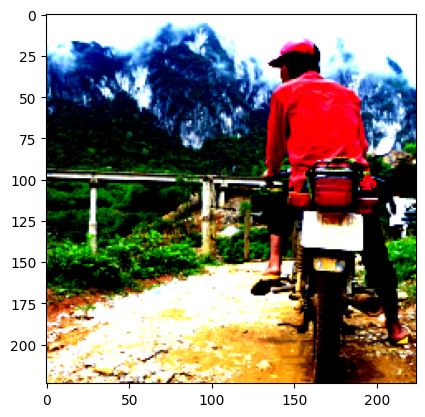

In [2]:
test_data = next(iter(coco_test_loader))
print(test_data[1])

print(test_data[0].shape)

plt.imshow(test_data[0][1].permute(1, 2, 0))
plt.show()

In [9]:
# clip_net = load_model('cuda')
model_name = "ViT-B/32"
CLIP_Net = clip.load(model_name, jit=False)[0].eval().float()

if model_name == "RN50":
    input_dim = 1024
    out_dim = 1024
else:
    input_dim = 512
    out_dim = 512

ProbVLM_Net = BayesCap_for_CLIP(
    inp_dim=input_dim,
    out_dim=out_dim,
    hid_dim=256,
    num_layers=3,
    p_drop=0.05,
)
# load ProbVLM_Net

ProbVLM_Net.load_state_dict(torch.load("ProbVLM/models/ProbVLM_Net_best_B.pth"))

<All keys matched successfully>

In [10]:
from utils import *
from ProbVLM.src.losses import *
from sample import *

test_data = next(iter(coco_test_loader))
# test_data = next(iter(coco_train_loader))

image = test_data[0].cuda()
cap = test_data[1].cuda()

print(image.shape)

CLIP_Net.eval()
ProbVLM_Net.eval().cuda()


with torch.no_grad():
    image_emb = CLIP_Net.encode_image(image)
    text_emb = CLIP_Net.encode_text(cap)

print(image_emb.shape, text_emb.shape)
mu_cap, alpha_cap, sigma_cap = ProbVLM_Net.txt_BayesCap(text_emb)
mu_img, alpha_img, sigma_img = ProbVLM_Net.img_BayesCap(image_emb)

# alpha_cap = torch.ones_like(alpha_cap)*30
# sigma_cap = torch.ones_like(sigma_cap)

GGL = GenGaussLoss()



p_sp = -GGL(mu_cap[0], alpha_cap[0], sigma_cap[0],mu_img[0])
p_li = -GGL(mu_cap[1], alpha_cap[1], sigma_cap[1],mu_img[0])

print(alpha_cap[0])

r = np.exp(np.min([0,(p_sp-p_li).item()]))
print(torch.abs(mu_cap[0]-mu_img[0]).sum(),torch.abs(mu_cap[1]-mu_img[0]).sum())
print(alpha_cap[0].mean(),alpha_cap[1].mean())
print(sigma_cap[0].mean(),sigma_cap[1].mean())
print(r, "\n")

p_sp = -GGL(mu_cap[2], alpha_cap[2], sigma_cap[2],mu_img[0])
p_li = -GGL(mu_cap[1], alpha_cap[1], sigma_cap[1],mu_img[0])

r = np.exp(np.min([0,(p_sp-p_li).item()]))
print(torch.abs(mu_cap[2]-mu_img[0]).sum(),torch.abs(mu_cap[1]-mu_img[0]).sum())
print(alpha_cap[2].mean(),alpha_cap[1].mean())
print(sigma_cap[2].mean(),sigma_cap[1].mean())
print(r, "\n")

p_sp = -GGL(mu_cap[3], alpha_cap[3], sigma_cap[3],mu_img[0])
p_li = -GGL(mu_cap[1], alpha_cap[1], sigma_cap[1],mu_img[0])

r = np.exp(np.min([0,(p_sp-p_li).item()]))
print(torch.abs(mu_cap[3]-mu_img[0]).sum(),torch.abs(mu_cap[1]-mu_img[0]).sum())
print(alpha_cap[3].mean(),alpha_cap[1].mean())
print(sigma_cap[3].mean(),sigma_cap[1].mean())
print(r, "\n")

p_sp = -GGL(mu_cap[4], alpha_cap[4], sigma_cap[4],mu_img[0])
p_li = -GGL(mu_cap[1], alpha_cap[1], sigma_cap[1],mu_img[0])

r = np.exp(np.min([0,(p_sp-p_li).item()]))
print(torch.abs(mu_cap[4]-mu_img[0]).sum(),torch.abs(mu_cap[1]-mu_img[0]).sum())
print(alpha_cap[4].mean(),alpha_cap[1].mean())
print(sigma_cap[4].mean(),sigma_cap[1].mean())
print(r, "\n")

p_sp = -GGL(mu_cap[5], alpha_cap[5], sigma_cap[5],mu_img[0])
p_li = -GGL(mu_cap[1], alpha_cap[1], sigma_cap[1],mu_img[0])

r = np.exp(np.min([0,(p_sp-p_li).item()]))
print(torch.abs(mu_cap[5]-mu_img[0]).sum(),torch.abs(mu_cap[1]-mu_img[0]).sum())
print(alpha_cap[5].mean(),alpha_cap[1].mean())
print(sigma_cap[5].mean(),sigma_cap[1].mean())
print(r, "\n")

p_sp = -GGL(mu_cap[6], alpha_cap[6], sigma_cap[6],mu_img[0])
p_li = -GGL(mu_cap[1], alpha_cap[1], sigma_cap[1],mu_img[0])

r = np.exp(np.min([0,(p_sp-p_li).item()]))
print(torch.abs(mu_cap[6]-mu_img[0]).sum(),torch.abs(mu_cap[1]-mu_img[0]).sum())
print(alpha_cap[6].mean(),alpha_cap[1].mean())
print(sigma_cap[6].mean(),sigma_cap[1].mean())
print(r, "\n")

p_sp = -GGL(mu_cap[7], alpha_cap[7], sigma_cap[7],mu_img[0])
p_li = -GGL(mu_cap[1], alpha_cap[1], sigma_cap[1],mu_img[0])

r = np.exp(np.min([0,(p_sp-p_li).item()]))
print(torch.abs(mu_cap[7]-mu_img[0]).sum(),torch.abs(mu_cap[1]-mu_img[0]).sum())
print(alpha_cap[7].mean(),alpha_cap[1].mean())
print(sigma_cap[7].mean(),sigma_cap[1].mean())
print(r, "\n")

torch.Size([8, 3, 224, 224])
torch.Size([8, 512]) torch.Size([8, 512])
tensor([692.7911,   0.0000,   0.0000, 694.1353, 750.2958, 675.0590,   0.0000,
          0.0000, 608.7443, 588.4637,   0.0000, 616.8742, 643.8768, 603.2184,
        662.2106, 539.7469, 440.3688, 610.6793, 615.2066, 347.4959, 566.9529,
        312.3415, 768.8916, 588.7325, 606.8829,   0.0000, 607.2822, 603.6716,
        681.3215, 681.3058, 556.0953, 669.4582, 599.6238, 598.1483, 634.3912,
        678.9868, 554.9911, 636.5291, 601.0234, 720.3519, 697.4171, 851.8525,
        527.7511, 657.2471, 533.2255, 506.6321, 650.7330, 554.8887,   0.0000,
          0.0000, 436.9907, 718.3474, 535.6498, 704.5125, 566.9040, 638.3506,
        646.3345, 621.7200, 603.8231, 538.1535, 651.8093, 542.0836, 627.9898,
        553.6388, 506.6105,   0.0000,   0.0000,   0.0000, 573.6121, 563.9295,
          0.0000, 653.9376, 666.5750, 614.6109, 665.0089, 601.5031, 551.7007,
        890.4948, 581.4669, 587.2669, 618.1088, 552.8787, 572.4531, 652

In [5]:
import torch
import torch.nn as nn
import clip
from CLIP_prefix_caption.train import *
import numpy as np


device = "cuda:1" if torch.cuda.is_available() else "cpu"

prefix_length = 40
prefix_length_clip = 40
prefix_dim = 512
num_layers = 8
mapping_type = "mlp"

model = ClipCaptionPrefix(prefix_length, clip_length=prefix_length_clip, prefix_size=prefix_dim, num_layers=num_layers, mapping_type=mapping_type)
model.load_state_dict(torch.load('CLIP_prefix_caption/coco_train/coco_prefix_latest.pt'))

image_encoder, preprocess = clip.load("ViT-B/32", device=device, jit=False)

data_dir = 'ProbVLM/dataset/coco/oscar_split_ViT-B_32_train.pkl'
dataset = ClipCocoDataset(data_dir, prefix_length, normalize_prefix=True)

Data size is 520000


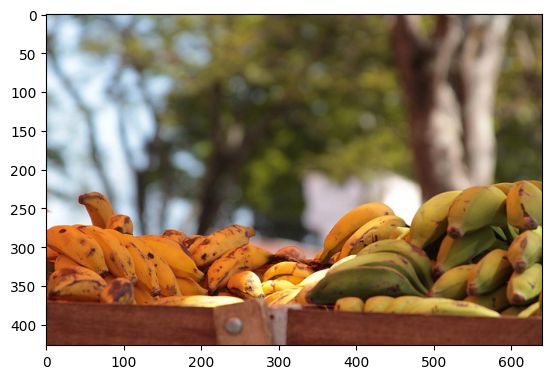

ClipCaptionPrefix(
  (gpt): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
  (clip_project): TransformerMap

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

A close up of a fruit tree with a bunch of bananas.


In [12]:
from utils import *
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt

filename = f"CLIP_prefix_caption/Images/COCO_val2014_000000579664.jpg"
image = io.imread(filename)

plt.imshow(image)
plt.show()

image = preprocess(Image.fromarray(image)).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = image_encoder.encode_image(image)


model = model.to(device).float()
prefix_embed = model.clip_project(image_features.float()).reshape(1, prefix_length, -1)
print(model)
print(tokenizer)
print(prefix_embed.shape)
generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
# generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)
print(generated_text_prefix)